# Data statistics

In [4]:
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from numpy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time
#Json
import json
#Os for file management
import os.path

RERUN = False #To rerun all computations (False will load from file if they exist)
NCORES_MAX = 4 #Maximal number of cores in use
extension = '.png' #fig file extension
#DIR  = 'D:/pdm_data/' #On desktop
DIR  = 'C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/' #On laptop

In [5]:
#Bentheimer 1000 parameters
Bentheimer1000 ={
'name'  :  'Bentheimer 1000',
'L0'    :  3.0,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  22.6,     #Pore length ratio [-]
'phi'   :  0.22,     #Porosity [%]
'kappa' :  1.65,     #Tortuosity
'lmbd/L':  8.32,     #Correlation length [-]
#Theta angle model
'omegat':  4.3,
'taut'  :  0.12,
'sigmat':  0.69,
'mut'   :  38.0,
#Beta angle model
'taub'  :  0.13,
'bb'    :  1.9,
#Log velocity magnitude model
'b'     :  0.57,
'c'     :  1.3,
'alpha' : -3.6,
'mu'    :  1.5,
'sigma' :  2.5
}

In [6]:
#Skew-normal PDF
def p_skew(v,sample) :
    alpha = sample['alpha']
    mu    = sample['mu']
    sigma = sample['sigma']
    p = 1/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))
    return p

def Save_data(MP_dict, filename) :
    #Copy data into non np array dict for json formating
    No_np = {}
    for key in MP_dict : No_np[key] = [v for v in MP_dict[key]]
    with open(filename, 'w') as outfile:  
        json.dump(No_np, outfile)
    
def Load_data(filename) :
    MP_dict = {}
    with open(filename, 'r') as outfile:  
        MP_dict = json.load(outfile)
    #Converting arrays in np array
    for key in MP_dict : MP_dict[key] = np.array(MP_dict[key])
    return MP_dict

def Extract_param (fname, param) :
    p_dict = {}
    for p_ in param :
        k  = 0
        for i in range(len(DIR),len(fname)) :
            if fname[i:i+len(p_)] == p_ :
                k = i+len(p_)
                break
        v_ = ''
        while (fname[k] != '_' and fname[k:k+2] != '.d') :
            v_ += fname[k]
            k  += 1
        p_dict[p_] = float(v_)
    return p_dict

# Loading rough and processed data

#### Data files 

In [7]:
DATA = {}

DM_ = ['0.0E0',
       '1.0E-13',
       '2.0E-13', 
       '5.0E-13', 
       '1.0E-12',
       '2.0E-12', 
       '5.0E-12', 
       '1.0E-11', 
       '2.0E-11', 
       '5.0E-11', 
       '1.0E-10',
       '2.0E-10',
       '5.0E-10',
       '1.0E-9',
       '1.0E-8',
       '1.0E-7',
       '1.0E-6',
       '1.0E-5']
KEYS   = ['Bent 1000, D='+dm+', CSF=40' for dm in DM_] #ORDERED ARRAY OF KEYS (IMPORTANT TO SORT DATA)
PLOT_KEYS = ['Bent 1000, D='+dm_+', CSF=20' for dm_ in ['0.0E0','1.0E-13','1.0E-12','1.0E-11','1.0E-10','1.0E-9','1.0E-8','1.0E-7','1.0E-6','1.0E-5']]

CASE   = 'Bentheimer1000'
for dm in DM_ : DATA['Bent 1000, D='+dm+', CSF=20'] = DIR+CASE+'/sl_out_M0_DM'+dm+'_SLSM0_TMAX2.0E7_CSF40.dat'

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
COLORS = {key : color for (key,color) in zip(PLOT_KEYS,color_cycle)}
print('Dataset to load : ' +str(len(DATA)))
PARAM = {}
param = ['DM','SLSM','TMAX','CSF']
for key in DATA : PARAM[key] = Extract_param (DATA[key],param)
D_VALUES = [PARAM[key]['DM'] for key in KEYS]

Dataset to load : 18


In [8]:
for key in DATA :
    if not os.path.isfile(DATA[key]) :
        print('Warning file from key : ' + key + 'not found')

#### Loading log velocity magnitude $$v = \ln{\left(\frac{\sqrt{u_x^2 + u_y^2 + u_z^2}}{U}\right)}$$

In [9]:
vDNS = {}; vfname = DIR+'Processed_data/vDNS.dat'
tDNS = {}; tfname = DIR+'Processed_data/tDNS.dat'
print('Loading vDNS...')
vDNS = Load_data(vfname)
print('Done.')
print('Loading tDNS...')
tDNS = Load_data(tfname)
print('Done.')

Loading vDNS...
Done.
Loading tDNS...
Done.


#### Loading isochronous lvm

In [12]:
#Dictionnary to store isochronous transforms with various dt
dt_factor = 1.0 #To choose the ratio between isochr dt and DNS mean dt
v_iso  = {}; vname = DIR+'Processed_data/v_iso_dt_fact_'+str(dt_factor)+'.dat';
t_iso  = {} #time (linspace(0,T,dt))
Nt_iso = {} #number of points
dt_iso = {}; dtname = DIR+'Processed_data/dt_iso_dt_fact_'+str(dt_factor)+'.dat';
print('Loading v_iso..')
v_iso = Load_data(vname)
print('Done.')
print('Loading dt_iso..')
dt_iso = Load_data(dtname)
print('Done.')
    
Nt_iso = { key : len(v_iso[key]) for key in v_iso }
t_iso  = { key : np.linspace(0,tDNS[key][-1],Nt_iso[key]) for key in v_iso }

Load v_iso..
Done.
Load dt_iso..
Done.


## Probability density functions

In [13]:
## Some useful functions to handle pdf
def Save_pdf(pdf_dict, filename) :
    #Copy data into non np array dict for json formating
    x = {}
    y = {}
    for key in pdf_dict : x[key] = [v for v in pdf_dict[key][0]]
    for key in pdf_dict : y[key] = [v for v in pdf_dict[key][1]]
    with open(filename, 'w') as outfile:  
        json.dump([x,y], outfile)
        
def Load_pdf(filename) :
    x = {}
    y = {} 
    pdf_ = {}
    with open(filename, 'r') as outfile:  
        data = json.load(outfile)
    x = data[0]
    y = data[1]
    for key in x : pdf_[key] = [np.array(x[key]),np.array(y[key])]    
    return pdf_

def Extract_pdf(data_, nbins = 500, dst = True) :
    pdf_ = np.histogram(data_, bins = nbins, density = dst);
    pdf_ = np.array([pdf_[1][0:-1], pdf_[0]])
    return pdf_

def Return_mean(pdf_) :
    x = pdf_[0]; y = pdf_[1];
    return np.sum(x*y)/np.sum(y)

def Return_std(pdf_) :
    x    = pdf_[0]; y = pdf_[1];
    mu = Return_mean(pdf_)
    std  = np.sqrt(np.sum([(x_ - mu)**2*y_ for (x_,y_) in zip(x,y)])/np.sum(y))
    return std

def Return_skew(pdf_) :
    x    = pdf_[0]; y = pdf_[1];
    mu   = Return_mean(pdf_)
    std  = Return_std(pdf_)
    skew = np.sum([((x_ - mu)/std)**3*y_ for (x_,y_) in zip(x,y)])/np.sum(y)
    return skew

def mean_crossing_time(tdata) :
    T_  = []
    tm1 = 0
    for t_ in tdata :
        if tm1 > t_ : #If time is set to zero again (= end of the stream line)
            T_.append(tm1)
        tm1 = t_
    N_  = len(T_)
    mean_ = sum(T_)/N_
    return mean_

#### DNS directional velocities pdf and mean velocity for different diffusion coefficients

In [14]:
pvx_DNS = {}; vxmean = []; pdfvxfname = DIR+'Processed_data/pdf_vx.dat'
pvy_DNS = {}; vymean = []; pdfvyfname = DIR+'Processed_data/pdf_vy.dat'
pvz_DNS = {}; vzmean = []; pdfvzfname = DIR+'Processed_data/pdf_vz.dat'
if RERUN :
    print('Computing directional velocity pdf..')
    for key in KEYS :
        print (key)
        with open(DATA[key], 'r') as f:
            lines   = (line for line in f if (len(line)>100 and len(line)<150))
            dataDNS = np.genfromtxt(lines)
        del lines;
        pvx_DNS[key] = Extract_pdf(dataDNS[:,4]/Umean)
        pvy_DNS[key] = Extract_pdf(dataDNS[:,5]/Umean)
        pvz_DNS[key] = Extract_pdf(dataDNS[:,6]/Umean)
    del dataDNS    
    print('\tSaving..')
    Save_pdf(pvx_DNS,pdfvxfname)
    Save_pdf(pvy_DNS,pdfvyfname)
    Save_pdf(pvz_DNS,pdfvzfname)
    print('Done.')
else :
    print('Loading directional velocity pdf..')
    print('\t vx')
    pvx_DNS = Load_pdf(pdfvxfname)
    print('\t vy')
    pvy_DNS = Load_pdf(pdfvyfname)
    print('\t vz')
    pvz_DNS = Load_pdf(pdfvzfname)
    print('Done')
    
for key in KEYS :
    vxmean.append(Return_mean(pvx_DNS[key]))
    vymean.append(Return_mean(pvy_DNS[key]))
    vzmean.append(Return_mean(pvz_DNS[key]))

Loading directional velocity pdf..
	 vx
	 vy
	 vz
Done


#### Comparison between mean velocity magnitude and mean directional velocities (in log) for various diffusion coefficients

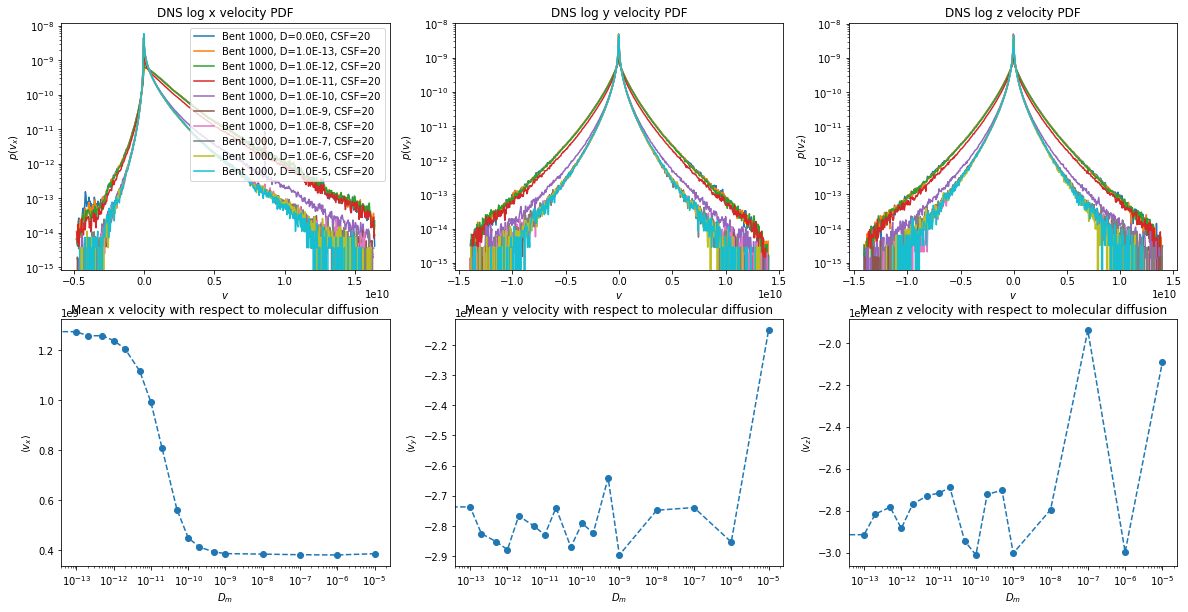

In [20]:
fig, axs = plt.subplots(2,3,figsize=(20,10))

(i,j) = (0,0)
axs[i,j].set_title('DNS log x velocity PDF')
for key in PLOT_KEYS : axs[i,j].semilogy(pvx_DNS[key][0], pvx_DNS[key][1],label = key)
axs[i,j].legend();
axs[i,j].set_xlabel(r'$v$');
axs[i,j].set_ylabel(r'$p(v_x)$');

(i,j) = (0,1)
axs[i,j].set_title('DNS log y velocity PDF')
for key in PLOT_KEYS : axs[i,j].semilogy(pvy_DNS[key][0], pvy_DNS[key][1],label = key)
#axs[i,j].legend();
axs[i,j].set_xlabel(r'$v$');
axs[i,j].set_ylabel(r'$p(v_y)$');

(i,j) = (0,2)
axs[i,j].set_title('DNS log z velocity PDF')
for key in PLOT_KEYS : axs[i,j].semilogy(pvz_DNS[key][0], pvz_DNS[key][1],label = key)
#axs[i,j].legend();
axs[i,j].set_xlabel(r'$v$');
axs[i,j].set_ylabel(r'$p(v_z)$');
#axs[i,j].set_xlim([-40000,40000]);

(i,j) = (1,0)
axs[i,j].set_title('Mean x velocity with respect to molecular diffusion')
axs[i,j].semilogx(D_VALUES,vxmean,'o--', color = color_cycle[0])
axs[i,j].set_xlabel(r'$D_m$');
axs[i,j].set_ylabel(r'$\langle v_x \rangle$');

(i,j) = (1,1)
axs[i,j].set_title('Mean y velocity with respect to molecular diffusion')
axs[i,j].semilogx(D_VALUES,vymean,'o--', color = color_cycle[0])
axs[i,j].set_xlabel(r'$D_m$');
axs[i,j].set_ylabel(r'$\langle v_y \rangle$')

(i,j) = (1,2)
axs[i,j].set_title('Mean z velocity with respect to molecular diffusion')
axs[i,j].semilogx(D_VALUES,vzmean,'o--', color = color_cycle[0])
axs[i,j].set_xlabel(r'$D_m$');
axs[i,j].set_ylabel(r'$\langle v_z \rangle$');

plt.savefig(DIR+'Figures/directional_speed_pdf'+extension)

### Log velocita magnitude PDF

In [33]:
pdf_vDNS     = {} #Log velocity magnitude probability density function extracted directly from DNS
pdf_vDNS_fname = DIR+'Processed_data/pdf_vDNS.dat'
pdf_viso     = {} #to store isochronous histogram as a line
pdf_viso_fname = DIR+'Processed_data/pdf_viso.dat'
vmean       = [] #Mean log velocity magnitude
vstd        = [] #Standard deviation
vskew       = [] #Skewness
MCT         = [] #Mean crossing time
vmean_iso   = [] #Mean log velocity magnitude

if os.path.isfile(pdf_vDNS_fname) and (not RERUN) : 
    print('Loading vDNS pdf..')
    pdf_vDNS = Load_pdf(pdf_vDNS_fname)
else : 
    print('Computing vDNS pdf..')
    pdf_vDNS = {key : Extract_pdf(vDNS[key]) for key in KEYS}
    print('\tSaving..')
    Save_pdf(pdf_vDNS, pdf_vDNS_fname)
print('Done.')

if os.path.isfile(pdf_viso_fname) and (not RERUN) : 
    print('Loading viso pdf..')
    pdf_viso = Load_pdf(pdf_viso_fname)
else : 
    print('Computing viso pdf..')
    pdf_viso = {key : Extract_pdf(vDNS[key]) for key in KEYS}
    print('\tSaving..')
    Save_pdf(pdf_viso, pdf_viso_fname)
print('Done.')

print('Computing MCT, mean, std and skewness..')
for key in KEYS :
    MCT.append(mean_crossing_time(tDNS[key]))
    vmean.append(Return_mean(pdf_vDNS[key]))
    vstd.append(Return_std(pdf_vDNS[key]))
    vskew.append(Return_skew(pdf_vDNS[key]))
    vmean_iso.append(Return_mean(pdf_viso[key]))
print('Done.')

Loading vDNS pdf..
Done.
Loading viso pdf..
Done.
Computing MCT, mean, std and skewness..
Done.


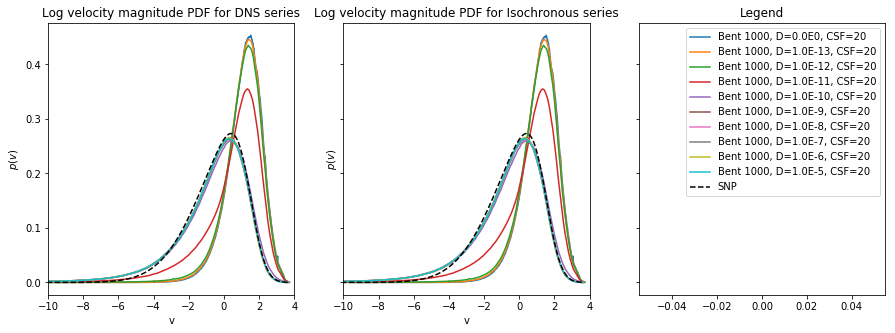

In [36]:
fig, axs = plt.subplots(1,3, figsize=(15,5), sharey=True);
axs[0].set_title('DNS log velocity magnitude PDF')
axs[0].set_title('Log velocity magnitude PDF for DNS series');
axs[0].set_xlabel('v')
axs[0].set_ylabel(r'$p(v)$')
for key in PLOT_KEYS : 
    axs[0].plot(pdf_vDNS[key][0],pdf_vDNS[key][1], label=key);
axs[0].plot(pdf_vDNS[key][0], p_skew(pdf_vDNS[key][0],Bentheimer1000), '--k', label = 'SNP');
#axs[0].legend();
axs[0].set_xlim([-10,4]);

axs[1].set_title('Log velocity magnitude PDF for Isochronous series');
axs[1].set_xlabel('v')
axs[1].set_ylabel(r'$p(v)$')
for key in PLOT_KEYS : 
    axs[1].plot(pdf_viso[key][0], pdf_viso[key][1], label=key)
axs[1].plot(pdf_viso[key][0], p_skew(pdf_viso[key][0],Bentheimer1000), '--k', label = 'SNP');
#axs[1].legend();
axs[1].set_xlim([-10,4]);

axs[2].set_title('Legend');
for key in PLOT_KEYS : 
    axs[2].plot(0,0, label=key)
axs[2].plot(0,0, '--k', label = 'SNP');
axs[2].legend();
plt.savefig(DIR+'Figures/DNS_vs_iso_large_range'+extension)

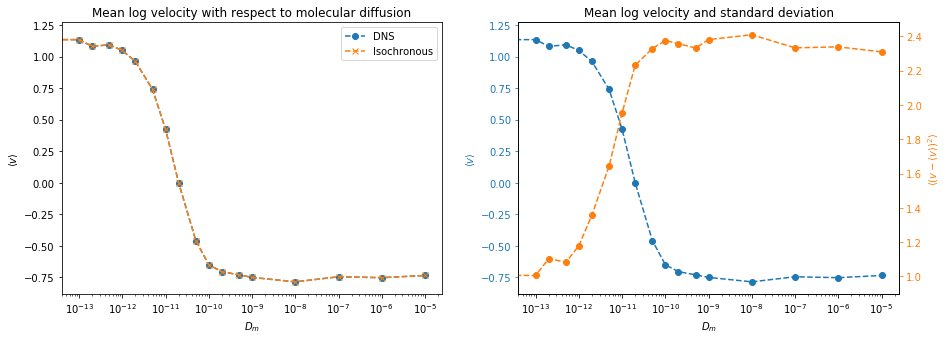

In [37]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

ax = axs[0]
ax.set_title('Mean log velocity with respect to molecular diffusion')
ax.semilogx(D_VALUES,vmean,'o--', color = color_cycle[0], label = 'DNS')
ax.semilogx(D_VALUES,vmean_iso,'x--', color = color_cycle[1], label = 'Isochronous')
ax.set_xlabel(r'$D_m$');
ax.set_ylabel(r'$\langle v \rangle$')
ax.legend();

ax = axs[1]
ax.set_title('Mean log velocity and standard deviation')
ax.semilogx(D_VALUES,vmean_iso,'o--', color = color_cycle[0])
ax.set_xlabel(r'$D_m$');
ax.set_ylabel(r'$\langle v \rangle$', color = color_cycle[0])
ax.tick_params('y', colors=color_cycle[0])

ax2 = ax.twinx()
ax2.semilogx(D_VALUES,vstd,'o--', color = color_cycle[1])
ax2.set_ylabel(r'$\langle (v - \langle v \rangle)^2 \rangle$', color = color_cycle[1])
ax2.tick_params('y', colors=color_cycle[1])

plt.savefig(DIR+'Figures/mean_v_to_dm'+extension)

#### Autocorrelation

We compute autocorrelation using the normalized estimator : 
$$ R(t_k= k dt) = \frac{1}{(N-k)\sigma^2}\sum_{t=0}^{N-k} (X_t-\mu)(X_{t+k}-\mu) $$

The cutting time $\tau_c$ that approach the distance between two closest uncorrelated measures is defined as the time where the tangent at $R(t_k=0)$ crosses the x-axis. 
This tangent is approximated as an $m$ points average slope as

$$ \partial R/\partial t|_{t_k=0} \approx \frac{R(t_m)-R(0)}{t_m - t_0} $$
leading to
$$ \tau_c = \frac{\Delta R}{\partial R/\partial t} \approx \frac{R(t_k=\tau_c)-R(t_k=0)}{(R(t_k=t_m) - R(t_k=0))/(t_m - t_0)}. $$

Per definition, $R(\tau_c)=0$ and $R(t_0=0)=1$ so the expression reduces to
$$ \tau_c = \frac{-t_m}{R(t_k=t_m)-1} $$

In [39]:
def autocorr_hm(x, Tmax, dt, Np, key) :
    mu    = np.mean(x)
    sigma = np.std(x)
    
    N     = len(x)
    Nk    = int(Tmax / dt)
    Nskip = max(1,Nk // Np)
    if Nskip == 1 : Np = min(Np,Nk)
    
    acf   = np.zeros(Np)
    trange= np.zeros(Np)
    i     = 0
    for i in range(Np):
        k = i*Nskip
        for t in range(0, N-k):
            acf[i] += 1.0/((N-k)*sigma**2)*(x[t]-mu)*(x[t+k]-mu)
        trange[i] = k*dt
    return (key, trange, acf) 

def parallel_autocorr(v_dict, Tmax = 0, Np = 50, Nmax = 1000, Nstart = 0) :
    v_autocorr = {}
    t_autocorr = {}
    results = Parallel(n_jobs=NCORES_MAX)(delayed(autocorr_hm)(v_dict[key][Nstart:Nstart+Nmax], Tmax, dt_iso[key][0], Np, key) for key in KEYS)
    for (key, t_, v_) in results :
        t_autocorr[key] = t_
        v_autocorr[key] = v_
    return (t_autocorr,v_autocorr)

def extract_cutting_time(x, acf, Np = 10) :
    tau = -x[Np]/(acf[Np]-1)
    return tau

In [43]:
Np   = 1000
Nmax = 40000
Tmax = 20
Nstart = 20000
v_autocorr = {}; vautocorrfname = DIR+'Processed_data/v_autocorr.dat'
t_autocorr = {}; tautocorrfname = DIR+'Processed_data/t_autocorr.dat'
if os.path.isfile(vautocorrfname) : 
    print('Loading autocorrelation functions..')
    v_autocorr = Load_data(vautocorrfname) 
    t_autocorr = Load_data(tautocorrfname)
else :
    print('Computing autocorrelation..')
    start = time.time()
    t_autocorr, v_autocorr = parallel_autocorr(v_iso, Tmax, Np, Nmax, Nstart)
    end   = time.time()
    print('\tTime needed : '+ str(end-start))
    print('Saving..')
    Save_data(v_autocorr, vautocorrfname)
    Save_data(t_autocorr, tautocorrfname)
print('Done.')

Loading autocorrelation functions..
Done.


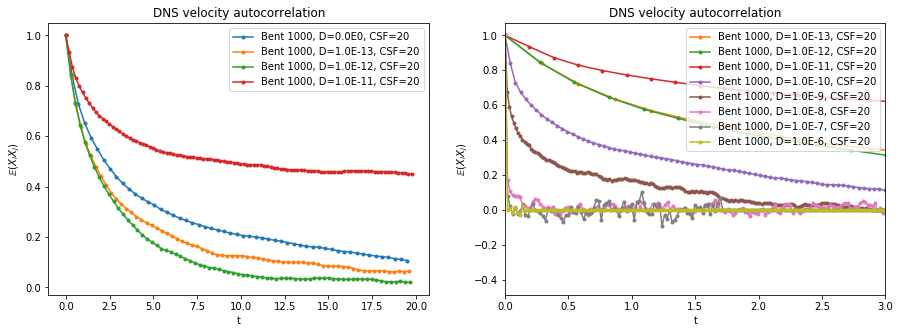

In [44]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

ax = axs[0]
ax.set_title('DNS velocity autocorrelation')
for key in PLOT_KEYS[0:4] :
    ax.plot(t_autocorr[key], v_autocorr[key], '.-', label = key, color = COLORS[key])
ax.set_xlabel('t')
ax.set_ylabel(r'$\mathbb{E}(X_i X_j)$')
ax.legend();

ax = axs[1]
ax.set_title('DNS velocity autocorrelation')
for key in PLOT_KEYS[1:-1] :
    ax.plot(t_autocorr[key], v_autocorr[key], '.-', label = key, color = COLORS[key])
ax.set_xlabel('t')
ax.set_ylabel(r'$\mathbb{E}(X_i X_j)$')
ax.set_xlim([0,3])
ax.legend();
plt.savefig(DIR+'Figures/v_autocorr'+extension)

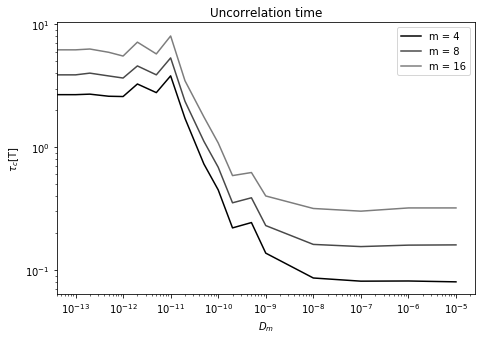

In [45]:
fig, ax = plt.subplots(1,1, figsize = (7.5,5.0))
ax.set_title('Uncorrelation time')
a_ = 1.0

for Np in [2**n for n in range(2,5)] :
    cutting_times = [extract_cutting_time(t_autocorr[key], v_autocorr[key], Np) for key in KEYS]
    ax.plot(D_VALUES, cutting_times,'-', label = 'm = '+str(Np), color ='k', alpha = a_)
    a_ /= 1.4

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$D_m$')
ax.set_ylabel(r'$\tau_c$[T]')
ax.legend();
plt.savefig(DIR+'Figures/autocorr_time'+extension)

## Modelization of the previous PDF

Behavior of mean log velocity and std are similar to function of the form :

$$ f(y; a_1,a_2,b,c) = \frac{a_1 \exp{[-c(y-b)]} + a_2 \exp{[c(y-b)]}}{\exp{[-c(y-b)]} + \exp{[c(y-b)}]} $$

where $a_1$,$a_2$ are left and right asymptotic behavior, respectively, $b$ the inflexion point position, $c$ the growth rate .

It can be useful to transform $f(x; a_1,a_2,b,c)$ into
$$ f(x; a_1,a_2,B,c) = \frac{a_1 B x^{-c} +  a_2 x^{c}}{B x^{-c} + x^{c}} $$
where $ x = e^y$ and $B = e^{2bc}$

In [46]:
def f(x,a1,a2,B,c) :
    up   = a1 * B * x**(-c) + a2 * x**c
    down = B * x**(-c) + x**c
    return up/down

Parameters found : $ v_a = 8.7, \quad v_d = 6.8, \quad b = \ln 10^{-11} $

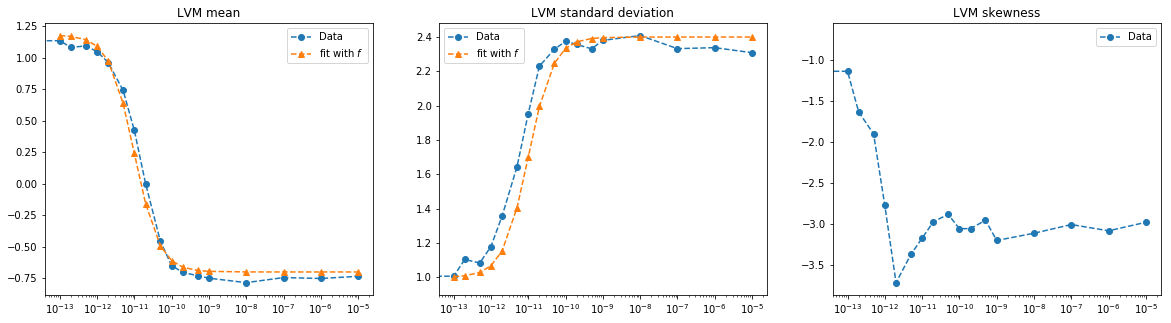

In [47]:
x = np.array([d_ for d_ in D_VALUES if d_ > 0])
va = 1.18; vd = -0.7;
b = np.log(1.0e-11); c  = 0.65; 
B = np.exp(2*b*c)
fig, axs = plt.subplots(1,3,figsize=(20,5))
axs[0].set_title('LVM mean')
axs[0].semilogx(D_VALUES,vmean,'o--', label='Data')
axs[0].semilogx(x,f(x,va,vd,B,c),'^--', label=r'fit with $f$')
axs[0].legend();

sm = 1.0; sp = 2.4;
axs[1].set_title('LVM standard deviation')
axs[1].semilogx(D_VALUES,vstd,'o--', label='Data')
axs[1].semilogx(x,f(x,sm,sp,B,c),'^--', label=r'fit with $f$')
axs[1].legend();

axs[2].set_title('LVM skewness')
axs[2].semilogx(D_VALUES,vskew,'o--', label='Data')
#axs[2].semilogx(x,f(x,sm,sp,B,c),'^--', label=r'fit with $f$')
axs[2].legend();

This behavior represent the variation of the mean of the skew normal pdf
$$ p(v; \mu, \sigma)=\frac{1}{\sqrt{2\pi}\sigma}\exp\left[-\frac{(v-\mu)^2}{2\sigma^2}\right](1-\textrm{erf}\left[-\frac{\alpha(v-\mu)}{\sqrt{2}\sigma}\right])$$
The mean, variance and skewness of skew normal pdf are given by 
$$\mu^* = \mu + \beta\sigma,\quad \sigma^* = \sigma \sqrt{ 1-\beta^2} \quad\textrm{and}\quad \alpha^* = \frac{4-\pi}{2}\frac{\beta^3}{(1-\beta^2)^{3/2}} \quad\textrm{with}\quad \beta := \sqrt{\frac{2}{\pi}}\frac{\alpha}{\sqrt{1+\alpha^2}}, $$
respectively

(Skewness defined as $\mathbb{E}\left[\left(\frac{X-\mu^*}{\sigma^*}\right)^3\right]$)

To fit our DNS pdf with skew normal pdf, the parameters $\mu,\sigma,\alpha$ must be set to reproduce the observed mean, variance and skewness of the data.
One can relate the skew normal pdf parameters $\mu,\sigma,\alpha$ to the mean, variance and skewness by inversing previous equations :
$$ \mu = \mu^* - \beta \sigma,\quad \sigma = \frac{\sigma^*}{\sqrt{1-\beta^2}} \quad\textrm{and}\quad \beta = \frac{\omega^*}{\sqrt{1+{\omega^*}^2}} \quad\textrm{with}\quad \omega^* :=\left(\frac{2}{4-\pi}\alpha^*\right)^{1/3}$$

The relation between the skewness $\alpha^*$ and our parameter $\alpha$ can be defined as :
$$  $$

In [49]:
def cbrt(x) :
    if x > 0 :
        return x**(1.0/3.0)
    else :
        return -((-x)**(1.0/3.0))

def beta_p(skew) :
    alpha = alpha_p(skew)
    return np.sqrt(2.0/np.pi)*alpha/np.sqrt(1+alpha**2)

def mu_p(avg, std, skew) :
    return avg - beta_p(skew) * std

def sigma_p(std, skew) :
    if beta_p(skew) < 1 :
        return std/np.sqrt(1-beta_p(skew))
    else :
        return std/np.sqrt(1+beta_p(skew))

def alpha_p(skew) :
    omega = cbrt(1.0*skew/(4.0-np.pi))
    if (1-2.0/np.pi)*omega**2 < 2.0/np.pi :
        return omega/np.sqrt(2.0/np.pi - (1-2.0/np.pi)*omega**2)
    else :
        return omega/np.sqrt(2.0/np.pi + (1-2.0/np.pi)*omega**2)
    
#Skew-normal PDF
def psk(v, avg, std, skew) :
    mu    = mu_p(avg, std, skew)
    sigma = sigma_p(std, skew)
    alpha = alpha_p(skew)
    return 1.0/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))

In [64]:
i = 0
v_stats = {}
for key in KEYS :
    tmp = {}
    tmp['avg']  = vmean[i]
    tmp['std']  = vstd[i]
    tmp['skew'] = vskew[i]
    v_stats[key] = tmp
    i+= 1

In [51]:
def Extract_param (fname, param) :
    p_dict = {}
    for p_ in param :
        k  = 0
        for i in range(len(DIR),len(fname)) :
            if fname[i:i+len(p_)] == p_ :
                k = i+len(p_)
                break
        v_ = ''
        while (fname[k] != '_' and fname[k:k+2] != '.d') :
            v_ += fname[k]
            k  += 1
        p_dict[p_] = float(v_)
    return p_dict

In [52]:
print(Extract_param(DATA[KEYS[1]],['DM']))

{'DM': 1e-13}


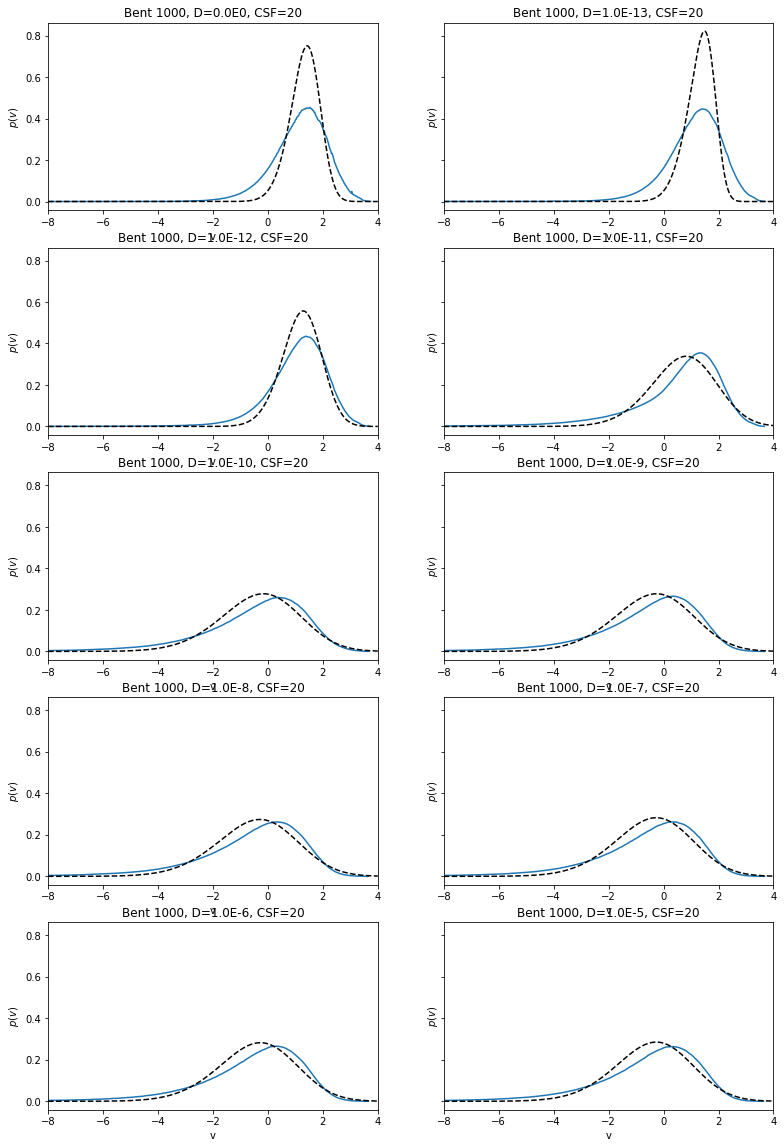

In [65]:
alpha = Bentheimer1000['alpha']
sigma = Bentheimer1000['sigma']
mu = Bentheimer1000['mu']
fig, axs = plt.subplots(5,2, figsize=(13,20), sharey=True);
PLOT_KEYS = ['Bent 1000, D='+dm_+', CSF=20' for dm_ in ['0.0E0','1.0E-13','1.0E-12','1.0E-11','1.0E-10','1.0E-9','1.0E-8','1.0E-7','1.0E-6','1.0E-5']]
V = np.linspace(-8,4,1000)
count    = 0
for key in PLOT_KEYS :
    d_ = Extract_param(DATA[key],['DM'])
    (i,j) = (int(count/2),np.mod(count,2))
    ax    = axs[i,j]
    ax.set_title(key);
    ax.plot(pdf_viso[key][0], pdf_viso[key][1])
    avg = v_stats[key]['avg']; std = v_stats[key]['std']; skew = v_stats[key]['skew']
    ax.plot(V, psk(V, avg, std, skew), '--k', label = 'SNP for D = '+str(d_['DM']))
    ax.set_xlim([-8,4])
    ax.set_xlabel('v')
    ax.set_ylabel(r'$p(v)$')
    count += 1
    
plt.savefig(DIR+'Figures/DNS_vs_iso'+extension)

### Comparison with Markovian processes

In [55]:
samples = [Bentheimer1000]
Nmp = 100
MP_params = {
'seed': None,
'v0'  : 1.5,
'dt'  : 0.005,
'Tmax': 300.0,
'csf' : 1.0
}
MP_lvm  = {'params' : MP_params}
fname   = DIR+'Markov_processes/MP_lvm.dat'
rerun   = False
if (not os.path.isfile(fname)) or rerun:
    for sample in samples :
        MP_lvm[sample['name']]  = Parallel(n_jobs=NCORES_MAX)(
            delayed(LVM_process)
            (sample, MP_params) for i in range(Nmp))
        MP_lvm[sample['name']]=np.reshape(MP_lvm[sample['name']],len(MP_lvm[sample['name']][0])*Nmp)
        Save_data(MP_lvm,fname)
else :
    print('Loading data...')
    MP_lvm = Load_data(fname)
    print('Done')

Loading data...
Done


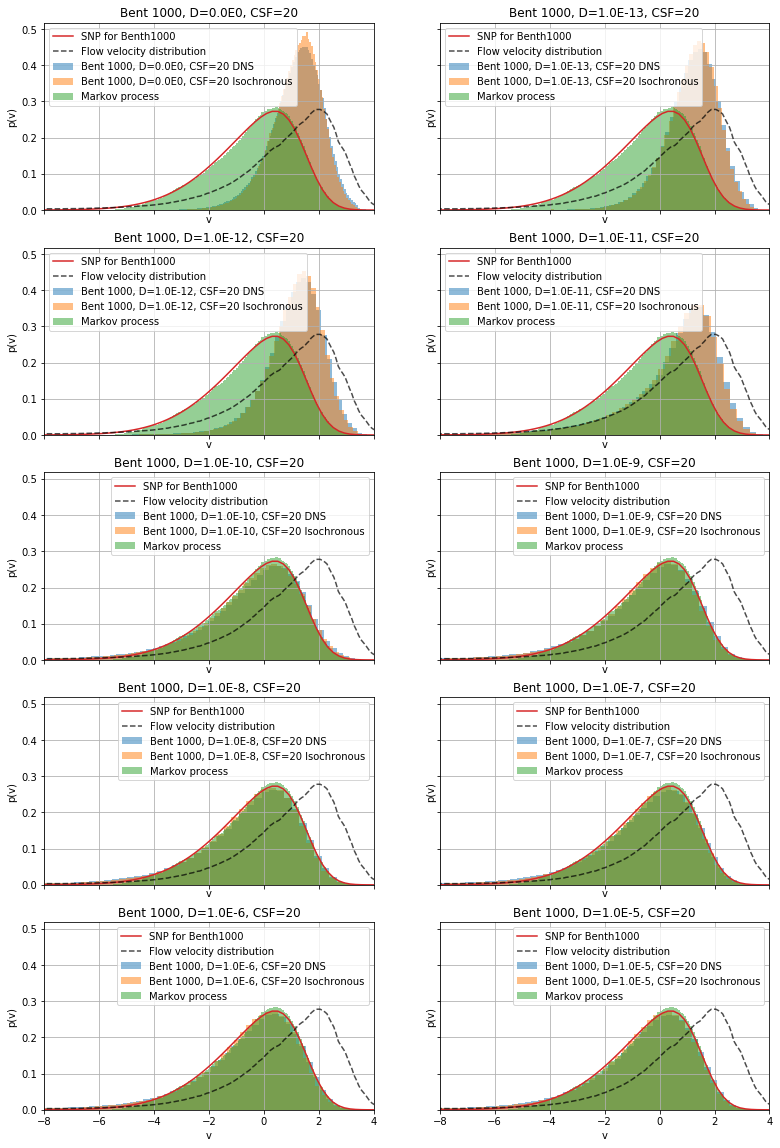

In [66]:
lvmpdf = Load_pdf(DIR+'Processed_data/bentheimer1000lvmpdf.dat')
fig, axs = plt.subplots(5,2,figsize=(13,20), sharex=True, sharey=True)
sample   = Bentheimer1000
vrange = np.linspace(-10,10,100)
count    = 0
for key in PLOT_KEYS :
    data1 = vDNS[key]
    data2 = v_iso[key]
    data3 = MP_lvm[sample['name']]
    (i,j) = (int(count/2),np.mod(count,2))
    axs[i,j].set_title('' + key)
    axs[i,j].hist(data1, bins = 200, label = key+' DNS',         density = True, alpha= 0.5)
    axs[i,j].hist(data2, bins = 200, label = key+' Isochronous', density = True, alpha= 0.5)
    axs[i,j].hist(data3, bins = 200, label = 'Markov process',   density = True, alpha= 0.5)
    axs[i,j].plot(vrange, p_skew(vrange,sample), label = 'SNP for Benth1000');
    axs[i,j].plot(lvmpdf['Bentheimer1000'][0], lvmpdf['Bentheimer1000'][1], '--k', label = 'Flow velocity distribution', alpha=0.7);
    axs[i,j].grid(True)
    axs[i,j].set_xlabel('v')
    axs[i,j].set_ylabel('p(v)')
    axs[i,j].legend()
    axs[i,j].set_xlim([-8,4])
    count += 1
del data1, data2, data3
plt.savefig(DIR+'Figures/summary'+extension)